In [11]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit 
from tqdm import tqdm
from numba import jit, prange
import pandas as pd

from aRead import readAREPO, readSinks
import constants as c
matplotlib.rcParams.update({'figure.dpi': 150})

In [2]:
# Open the snapshot
data = readAREPO("/scratch/c.c1922522/bigClouds/UV1000r2/cloudUV1000_080.hdf5", 1, tracers=True)
dataS = readSinks(1, "/scratch/c.c1922522/bigClouds/UV1000r2/sink_snap_080")

In [3]:
# Define class to hold sink data
class sink():
    pass

# Array to store the sink classes
sData = np.ones(data.nSinks, dtype=object)

# Loop through all sinks in the simulations
for i in range(data.nSinks):
    # Initialise sink class
    s = sink()
    
    # Get some attributes of the sink
    s.ID = data.sinkID[i]
    s.mass = data.sinkMass[i]
    s.formTime = dataS.formationTime[i]
    
    s.x = data.sinkX[i]
    s.y = data.sinkY[i]
    s.z = data.sinkZ[i]
    
    # Get the tracers that are in this sink
    s.tracers = data.tracerIDs[np.where(data.tracerParentIDs == s.ID)]
    
    # Assign to the array
    sData[i] = s

In [4]:
sinkMasses = np.zeros_like(sData)
for i in range(len(sData)):
    sinkMasses[i] = sData[i].mass
    
print(np.where(sinkMasses == np.max(sinkMasses)))
print(sData[297].formTime)

(array([297]),)
10.47210693359375


In [5]:
# Open the snapshot at the onset of sink formation
data = readAREPO("/scratch/c.c1922522/bigClouds/UV1000r2/cloudUV1000_052.hdf5", 1, tracers=True)

In [6]:
@jit(nopython=True)
def findTracerParents(sinkTracerIDs, tracerIDs, tracerParentIDs, particleIDs):
    # Array to store parent particle IDs
    parentIDs = np.zeros_like(sinkTracerIDs)
    parentLocation = np.zeros_like(sinkTracerIDs)
    
    # Loop through all the tracers we want to locate
    for i in prange(len(parentIDs)):
        # Loop through all the tracers 
        for j in range(len(tracerIDs)):
            if tracerIDs[j] == sinkTracerIDs[i]:
                parentIDs[i] = tracerParentIDs[j]
                break
            
        for j in range(len(particleIDs)):
            if particleIDs[j] == parentIDs[i]:
                parentLocation[i] = j
                break
            
    return parentIDs, parentLocation

In [8]:
#for i in tqdm(range(len(sData))):
for i in tqdm(range(len(sData))):
    _, pLoc = findTracerParents(sData[i].tracers, data.tracerIDs, data.tracerParentIDs, data.ids)
    
    dSink = np.sqrt((sData[i].x - data.x[pLoc])**2 + (sData[i].y - data.y[pLoc])**2 + (sData[i].z - data.z[pLoc]))
    sData[i].dists = dSink
    
    sData[i].distMass = dSink * data.mass[pLoc]

100%|██████████| 1504/1504 [06:30<00:00,  3.85it/s]


In [9]:
# Find the masses of each of the sinks we have
sMasses = np.zeros_like(sData)

for i in range(len(sData)):
    sMasses[i] = sData[i].mass

# Create bins of mass
massBins = 10**np.linspace(np.log10(np.min(sMasses)), np.log10(np.max(sMasses)), 20)

# Find the distances in each mass bin
distances = []
for i in range(len(massBins)-1):
    inBin = np.where((sMasses > massBins[i]) & (sMasses < massBins[i+1]))
    sinks = sData[inBin]
    
    # Gather all the distances into one array
    allDists = []
    for j in range(len(sinks)):
        dists = sinks[j].distMass.tolist()
        for dist in dists:
            allDists.append(dist)
        
    # Add to the total distances list for the bin
    distances.append(allDists)

Text(0, 0.5, 'Distance of Tracer to Sink at Formation')

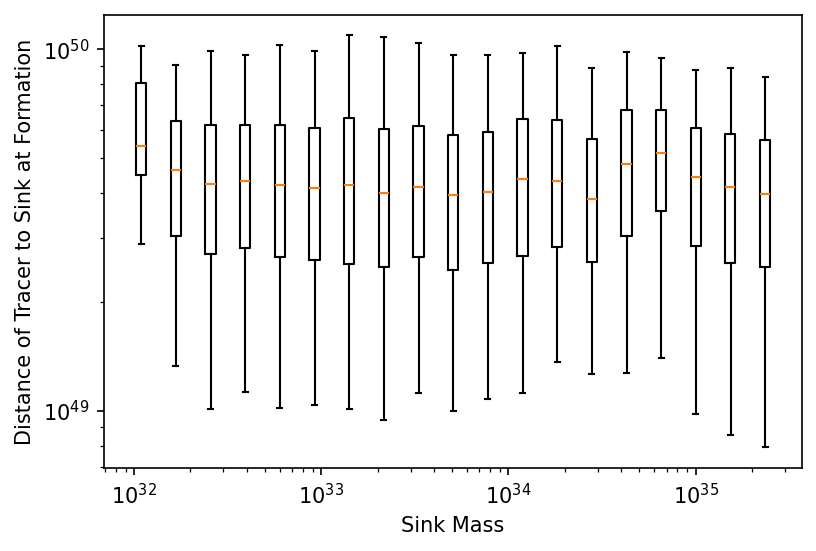

In [12]:
h = plt.boxplot(distances, positions=massBins[1:], widths=massBins[1:]/8, showfliers=False, whis=(5,95))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Sink Mass")
plt.ylabel("Distance of Tracer to Sink at Formation")

In [39]:
sMasses = np.zeros_like(sData)
sDists = np.zeros_like(sData)

for i in range(len(sData)):
    sMasses[i] = sData[i].mass
    sDists[i] = np.median(sData[i].dists)
    
plt.plot(sMasses, sDists, "bo", markersize=1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sink Mass")
plt.ylabel("Mean Distance of Accreted Particles")

AttributeError: 'sink' object has no attribute 'dists'

In [42]:
h = plt.hist(np.log10(sData[298].dists/1.5e13))
plt.xlabel("Distance of Tracer to Sink when it formed (log AU)")

AttributeError: 'sink' object has no attribute 'dists'